<img src='../images/copernicus_eumetsat_logo.jpg' alt='Copernicus EUMETSAT' align='right' width='50%'></img>

# $NO_2$ retrieval
For this exercise we will download a dataset of $NO_2$ concentration from the TROPOMI instrument on board the Copernicus Sentinel-5p satellite. The dataset can be donloaded from the [Copernicus Dataspace](https://dataspace.copernicus.eu/). In order to download the dataset we have to select an area of interest, the dates, and the product. From the menu we select: Sentinel-5p -> TROPOMI -> Level-2 NO2. The tool can show us the available products. After the download we can use [Panoply](https://www.giss.nasa.gov/tools/panoply/) to have a look at the structure of the dataset.  

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import matplotlib.colors as mcol
from matplotlib.colors import ListedColormap
from zipfile import ZipFile
import netCDF4 as nc4

In [2]:
path = 'data/S5P_NRTI_L2_NO2_20240815/'
filename = 'S5P_NRTI_L2_NO2_20240815.nc'

In [3]:
no2_product_ds = xr.open_dataset(path + filename, group='PRODUCT')
no2_product_ds

<xarray.Dataset>
Dimensions:                                               (scanline: 373,
                                                           ground_pixel: 450,
                                                           time: 1, corner: 4,
                                                           polynomial_exponents: 6,
                                                           intensity_offset_polynomial_exponents: 1,
                                                           layer: 34,
                                                           vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column                   (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...

## $NO_2$ tropospheric column

In [22]:
no2_tropospheric_column = no2_product_ds['nitrogendioxide_tropospheric_column'].sel(time='2024-08-15')
no2_tropospheric_column

<xarray.DataArray 'nitrogendioxide_tropospheric_column' (scanline: 373,
                                                         ground_pixel: 450)>
[167850 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 3.0 ... 369.0 370.0 371.0 372.0
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 447.0 448.0 449.0
    time          datetime64[ns] 2024-08-15
    latitude      (scanline, ground_pixel) float32 ...
    longitude     (scanline, ground_pixel) float32 ...
Attributes:
    units:                                                 mol m-2
    standard_name:                                         troposphere_mole_c...
    long_name:                                             Tropospheric verti...
    ancillary_variables:                                   nitrogendioxide_tr...
    multiplication_factor_to_convert_to_molecules_percm2:  6.02214e+19

In [23]:
bb_north = 47.5037
bb_south = 34.8262
bb_west = 5.8990
bb_east = 20.7212
area_of_interest = [bb_north, bb_west, bb_south, bb_east]

In [24]:
def create_figure(): 
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.LAND, edgecolor='black')
    ax.coastlines()
    ax.set_extent([bb_west, bb_east, bb_south, bb_north], ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    return fig, ax

Text(0.5, 1.0, 'NO2 Tropospheric Column - 2024-08-15')

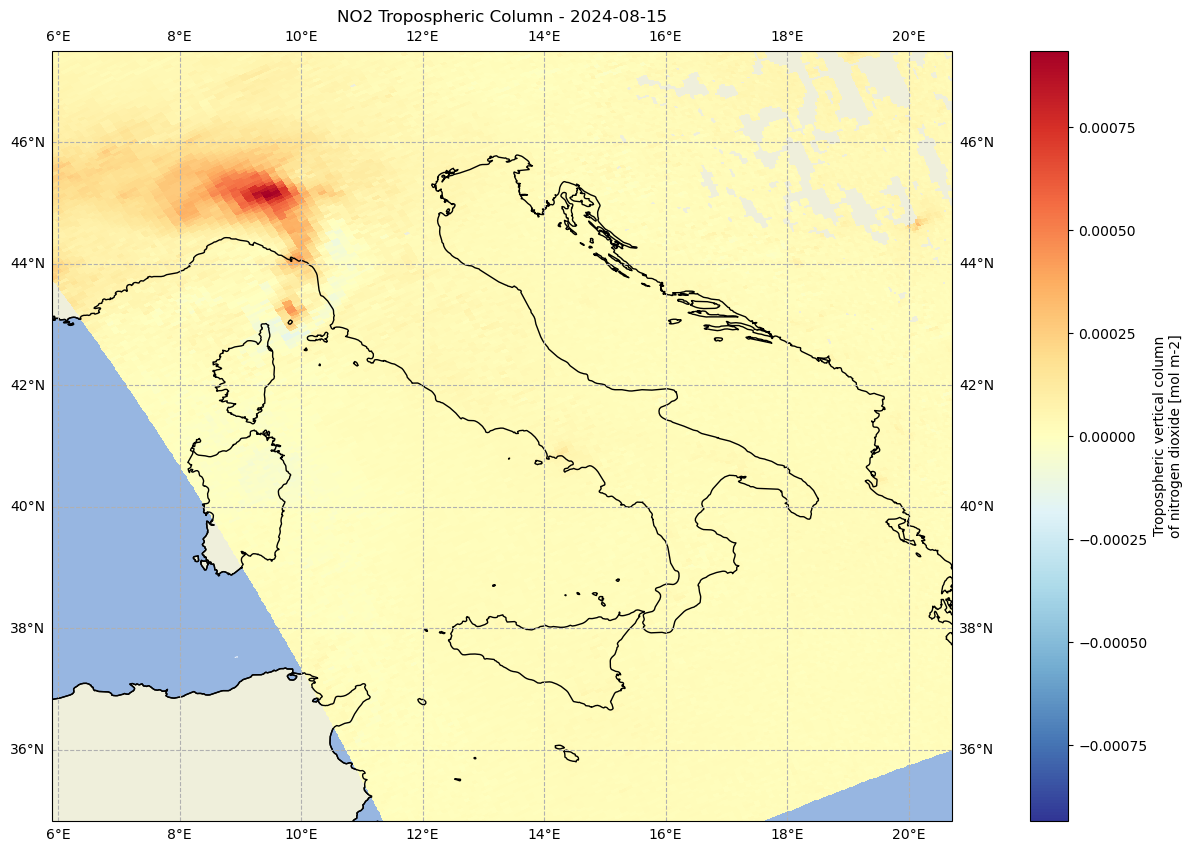

In [25]:
_, ax = create_figure()
no2_tropospheric_column.plot.pcolormesh(ax=ax, x='longitude', y='latitude', add_colorbar=True, cmap='RdYlBu_r')
ax.set_title('NO2 Tropospheric Column - 2024-08-15')

## Averaging kernel

In [26]:
no2_averaging_kernel = no2_product_ds['averaging_kernel'].sel(time='2024-08-15')
no2_averaging_kernel

<xarray.DataArray 'averaging_kernel' (scanline: 373, ground_pixel: 450,
                                      layer: 34)>
[5706900 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 3.0 ... 369.0 370.0 371.0 372.0
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 447.0 448.0 449.0
    time          datetime64[ns] 2024-08-15
  * layer         (layer) float64 0.0 1.0 2.0 3.0 4.0 ... 30.0 31.0 32.0 33.0
    latitude      (scanline, ground_pixel) float32 ...
    longitude     (scanline, ground_pixel) float32 ...
Attributes:
    units:                1
    long_name:            Averaging kernel
    ancillary_variables:  tm5_constant_a tm5_constant_b tm5_tropopause_layer_...

Text(0.5, 1.0, '$NO_2$ Averaging kernel layer 0 - 2024-08-15')

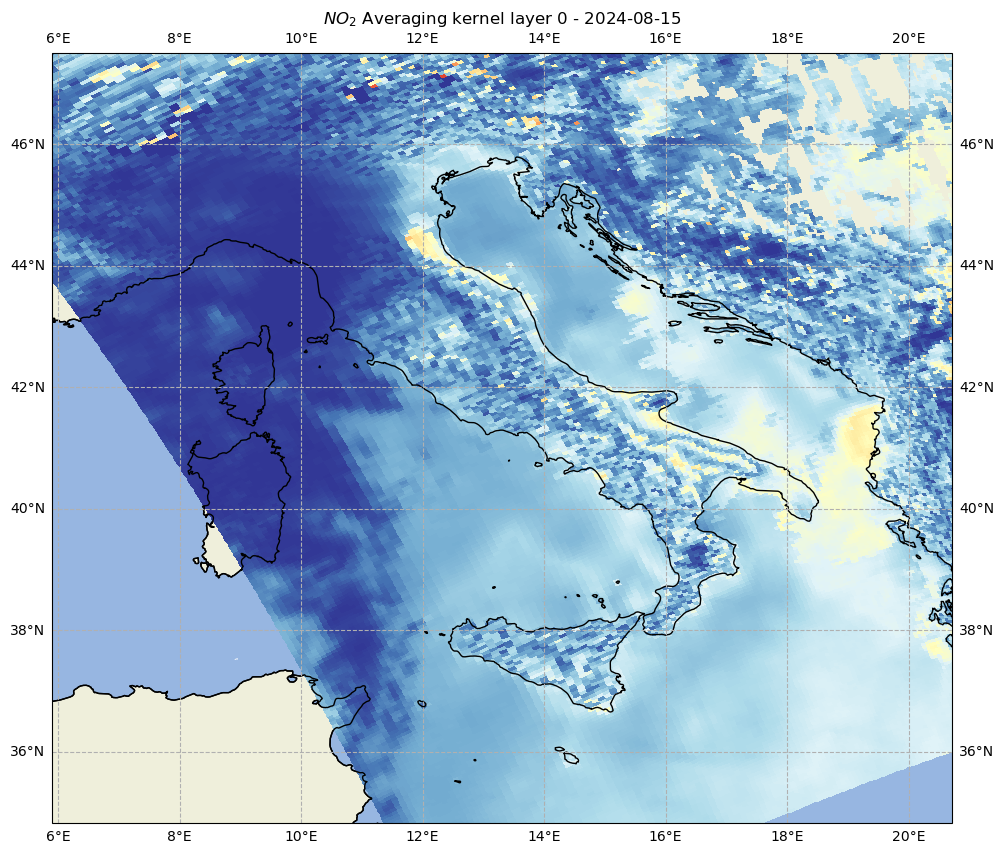

In [27]:
layer = 0
_, ax = create_figure()
plt.pcolormesh(no2_averaging_kernel.longitude, 
               no2_averaging_kernel.latitude, 
               no2_averaging_kernel.sel(layer=layer),
               cmap='RdYlBu_r',
               shading='auto',
               transform=ccrs.PlateCarree())
plt.title('$NO_2$ Averaging kernel layer {:d} - 2024-08-15'.format(layer))

## $NO_2$ tropospheric column data filtering
We filter the $NO_2$ tropospheric column data for quality value > 0.75

In [28]:
no2_quality = no2_product_ds['qa_value'].sel(time='2024-08-15')
no2_quality

<xarray.DataArray 'qa_value' (scanline: 373, ground_pixel: 450)>
[167850 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 3.0 ... 369.0 370.0 371.0 372.0
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 447.0 448.0 449.0
    time          datetime64[ns] 2024-08-15
    latitude      (scanline, ground_pixel) float32 ...
    longitude     (scanline, ground_pixel) float32 ...
Attributes:
    units:      1
    valid_min:  0
    valid_max:  100
    long_name:  data quality value
    comment:    A continuous quality descriptor, varying between 0 (no data) ...

In [33]:
no2_tropospheric_column_filtered = no2_tropospheric_column.where(no2_quality > 0.75)
no2_tropospheric_column_filtered.shape

(373, 450)

Text(0.5, 1.0, 'Filtered NO2 Tropospheric Column (qa > 0.8) - 2024-08-15')

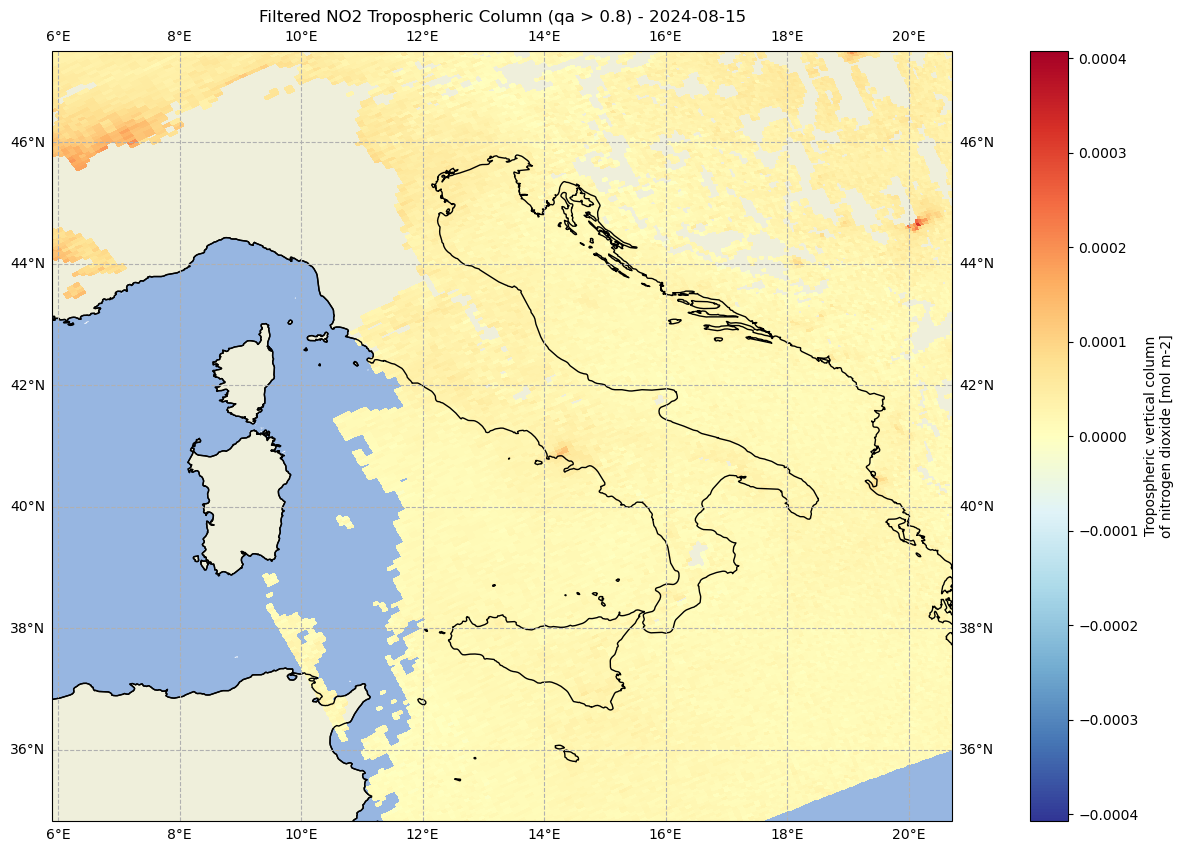

In [34]:
_, ax = create_figure()
no2_tropospheric_column_filtered.plot.pcolormesh(ax=ax, x='longitude', y='latitude', add_colorbar=True, cmap='RdYlBu_r')
ax.set_title('Filtered NO2 Tropospheric Column (qa > 0.8) - 2024-08-15')